# New York City Taxi Fare Prediction

I got this dataset from a [Kaggle Competition](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview). From the competition description:

> In this playground competition [...] you are tasked with predicting the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations. **While you can get a basic estimate based on just the distance between the two points, this will result in an RMSE of \\$5 - $8**, depending on the model used [...]. Your challenge is to do better than this using Machine Learning techniques!

Two separate datasets are provided:

>`train.csv` - Input features and target fare_amount values for the training set (about 55M rows).<br>
>`test.csv` - Input features for the test set (about 10K rows). Your goal is to predict fare_amount for each row.

More information is given in the description, but since it can be deduced from the exploration of the dataset, that is what I am doing.

Well, first thing let me import dependencies I am quite sure to need.

## Loading dependencies

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from datetime import datetime

## Loading the training set

Now I will have a quick peek at the training set.

In [2]:
!head train.csv

key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.84161,40.712278,1
2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.76127,-73.991242,40.750562,2
2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.98713,40.733143,-73.991567,40.758092,1
2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.73163,-73.972892,40.758233,1
2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1
2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.9513,40.774138,-73.990095,40.751048,1
2012-12-03 13:10:00.000000125,9,2012-12-03 13:10:00 UTC,-74.006462,40.726713,-73.99

The dataset contains an identifier column called `key` composed of date/time information, then the dependent variable called `fare_amount`, then some information on the taxi run: the date/time the passengers were picked up, the locations (latitude and longitude, in degrees) of pickup and dropoff, and the passenger count.

Well, I know from the description that this dataset is very large, containing around 55M instances. For this exercise, I will choose to work with a sample of the original file. First thing is to check exactly how many rows the file has.

In [3]:
number_rows_in_file = sum(1 for line in open('train.csv'))
print(number_rows_in_file)

55423857


I should bear in mind that this number includes the first row, which is the header.

Then, I will take my chances sampling 250,000 random entries from this dataset.

In [4]:
sample_size = 250_000

I could load the whole file then sample, but with a file that large, I might risk it not fitting into memory. Loading only the necessary rows seem more reasonable.

I am using Pandas `read_csv` function to do the job. Instead of giving it the rows I want to load as a parameter, this function asks for the rows to skip. Therefore, I will create a list containing the indices for the rows to skip. The range of integers to be sampled from should start at 1, since I want to keep row 0 (the header), and go until the end of the file. The number of samples should be `number_rows_in_file` minus `sample_size`.

In [5]:
random.seed(24)
skiprows = sorted(random.sample(range(1, number_rows_in_file + 1), number_rows_in_file - sample_size))

Now I can pass this argument to `read_csv` and load the chosen amount of information.

In [6]:
train = pd.read_csv('train.csv', skiprows = skiprows)

Since the operations above are quite time-consuming, I will choose to save the sampled dataset to disk, so I can load it again whether necessary. The filename will have an index discriminating the sample size.

In [7]:
train.to_csv('train_sample_'+str(sample_size)+'.csv', index = False)

Now I will reload it in the `train` variable, but this time explicitly mentioning the datatypes I am expecting each column to be treated as.

In [8]:
train = pd.read_csv('train_sample_'+str(sample_size)+'.csv', parse_dates = ['key', 'pickup_datetime'], 
                    dtype = {'fare_amount': np.float32, 
                             'pickup_latitude': np.float32, 
                             'pickup_longitude': np.float32,
                             'dropoff_latitude': np.float32,
                             'dropoff_longitude': np.float32,
                             'passenger_count': np.int32})

## Cleaning the training set

First thing I will do is to check if there are any empty values.

In [9]:
train.isna().sum(axis = 0)

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

None! No dropping or imputing needed.

Now I will check each feature for consistency. To save me some typing, I will first copy the column to a new variable. 

### Dates

#### `key`

In [10]:
key = train['key']

I will check some basic statistics on it.

In [11]:
key.describe()

count                            250000
unique                           249991
top       2012-03-30 15:32:00.000000200
freq                                  2
first     2009-01-01 00:37:17.000000100
last      2015-06-30 23:59:45.000000100
Name: key, dtype: object

Almost all entries are unique. The first entry is from early 2009, and the last is from mid 2015, spawning therefore 6.5 years. I notice that the seconds have that weird decimals. Checking the documentation, it mentions:

> `key` - Unique string identifying each row in both the training and test sets. Comprised of `pickup_datetime` plus a unique integer, but this doesn't matter, it should just be used as a unique ID field. [...] Not necessarily needed in the training set [...].

So they are not decimals, but that unique integer thing. What a weird way to add an identifier, huh? That aside, I could simply chose to drop this column right away, as it is not necessary, but I will pretend I did not know that and keep it for now.

Going on, another thing I like to do in this step is to see a distribution of the values.

C:\Users\Denny\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


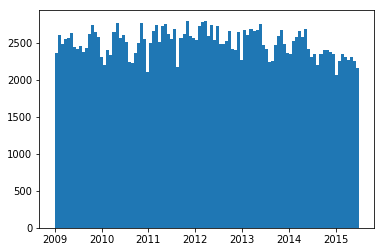

In [12]:
plt.hist(key, bins = 100);

The frequency is quite uniformly distributed, nothing extraordinary caught my attention here.

#### `pickup_datetime`

In [13]:
pdt = train['pickup_datetime']
pdt.describe()

count                        250000
unique                       244650
top       2013-04-04 20:25:00+00:00
freq                              4
first     2009-01-01 00:37:17+00:00
last      2015-06-30 23:59:45+00:00
Name: pickup_datetime, dtype: object

Almost all are also unique. But now, I notice that the first and last entries are equal to those in the `key` column. Hmm. What if [the description did not lie after all and] all entries are equal in both columns?

In order to check that, first I need to format the two columns equally so I can compare them. In `key`, I can drop those decimals formating the entries so that seconds are integers. In `pdt`, I can drop the timezone information. Then, compare.

In [14]:
pdt = pdt.map(lambda date: date.tz_localize(None))
key = pd.to_datetime(key.dt.strftime('%Y-%m-%d %H:%M:%S'))
(key == pdt).value_counts()

True    250000
dtype: int64

They are all equal, indeed! So I will chose to drop the `key` column from the training set, and update the `pickup_datetime` column to strip it off the tmz component.

In [15]:
train.drop(['key'], axis = 1, inplace = True)
train['pickup_datetime'] = pdt

### Coordinates

#### `pickup_longitude`

In [16]:
plon = train['pickup_longitude']
plon.describe()

count    250000.000000
mean        -72.528488
std          15.740434
min       -3384.713135
25%         -73.992073
50%         -73.981812
75%         -73.967024
max        2889.983887
Name: pickup_longitude, dtype: float64

Values within the 25-75 quantiles are consistent, but the minimum and maximum values make no sense.

Let me check the distribution of values.

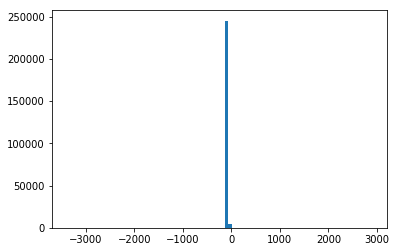

In [17]:
plt.hist(plon, bins = 100);

Most value seem indeed to be around -74. Let me zoom in 2.5 degrees around the median.

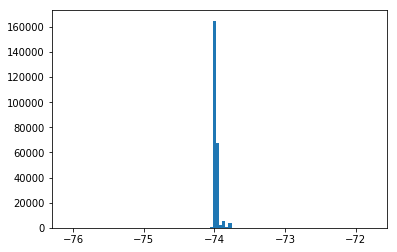

In [18]:
plt.hist(plon[(plon > plon.median() - 2.5) & (plon < plon.median() + 2.5)], bins = 100);

I choose to consider valid values within 0.5 degree around the median.

In [19]:
plon_val = (plon > plon.median() - 0.5) & (plon < plon.median() + 0.5)
print(plon_val.value_counts(), '\n', plon_val.value_counts(normalize = True))

True     244905
False      5095
Name: pickup_longitude, dtype: int64 
 True     0.97962
False    0.02038
Name: pickup_longitude, dtype: float64


Dropping 5095 entries (2.0%) with these conditions.

#### `pickup_latitude`

In [20]:
plat = train['pickup_latitude']
plat.describe()

count    250000.000000
mean         39.972263
std           8.903992
min       -2108.157715
25%          40.734966
50%          40.752640
75%          40.767147
max        1978.489990
Name: pickup_latitude, dtype: float64

Same kind of inconsistencies.

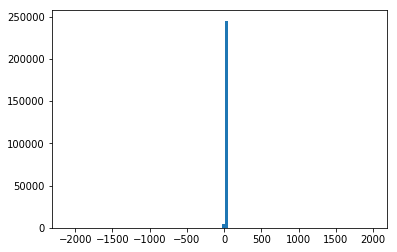

In [21]:
plt.hist(plat, bins = 100);

Same profile again. Zooming in:

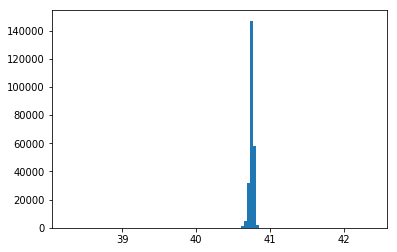

In [22]:
plt.hist(plat[(plat > plat.median() - 2.5) & (plat < plat.median() + 2.5)], bins = 100);

Let me also chose valid entries in a 0.5 degree range around the median.

In [23]:
plat_val = (plat > plat.median() - 0.5) & (plat < plat.median() + 0.5)
print(plat_val.value_counts(), '\n', plat_val.value_counts(normalize = True))

True     244945
False      5055
Name: pickup_latitude, dtype: int64 
 True     0.97978
False    0.02022
Name: pickup_latitude, dtype: float64


5055 entries (2.0%) selected to be dropped.

#### `dropoff_longitude`

In [24]:
dlon = train['dropoff_longitude']
dlon.describe()

count    250000.000000
mean        -72.546288
std          14.218449
min       -3047.714844
25%         -73.991402
50%         -73.980103
75%         -73.963638
max        2554.397217
Name: dropoff_longitude, dtype: float64

By now it seems the inconsistencies in coordinates are the same. Let me plot side by side the two histograms I have been making.

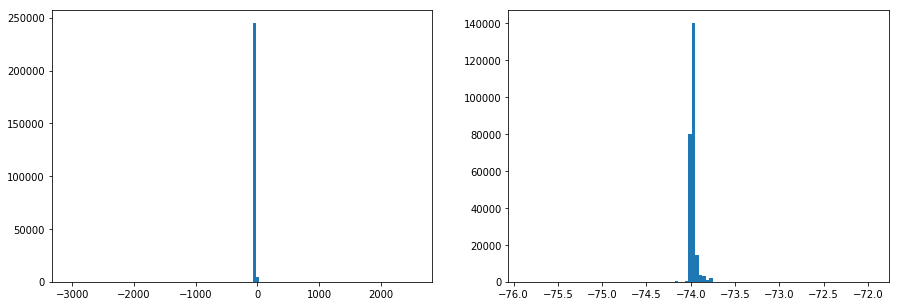

In [25]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].hist(dlon, bins = 100);
ax[1].hist(dlon[(dlon > dlon.median() - 2.5) & (dlon < dlon.median() + 2.5)], bins = 100);

The same conditions for validity seem to apply. Therefore:

In [26]:
dlon_val = (dlon > dlon.median() - 0.5) & (dlon < dlon.median() + 0.5)
print(dlon_val.value_counts(), '\n', dlon_val.value_counts(normalize = True))

True     244950
False      5050
Name: dropoff_longitude, dtype: int64 
 True     0.9798
False    0.0202
Name: dropoff_longitude, dtype: float64


5050 entries (2.0%) dropped.

#### `dropoff_latitude`

In [27]:
dlat = train['dropoff_latitude']
dlat.describe()

count    250000.000000
mean         39.981991
std          10.486096
min       -2450.704834
25%          40.734032
50%          40.753296
75%          40.768162
max        2561.559082
Name: dropoff_latitude, dtype: float64

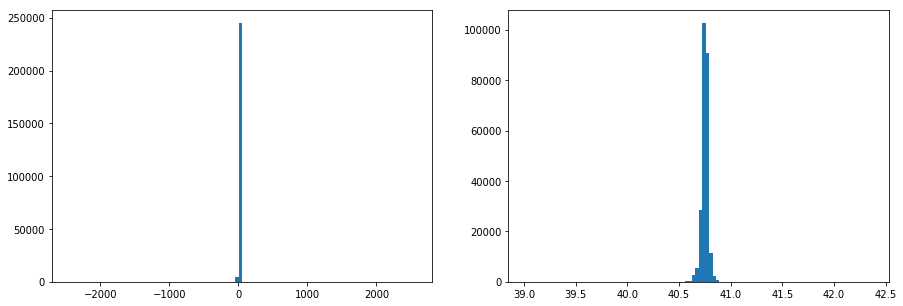

In [28]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].hist(dlat, bins = 100);
ax[1].hist(dlat[(dlat > dlat.median() - 2.5) & (dlat < dlat.median() + 2.5)], bins = 100);

I will also consider the same conditions for validity.

In [29]:
dlat_val = (dlat > dlat.median() - 0.5) & (dlat < dlat.median() + 0.5)
print(dlat_val.value_counts(), '\n', dlat_val.value_counts(normalize = True))

True     244964
False      5036
Name: dropoff_latitude, dtype: int64 
 True     0.979856
False    0.020144
Name: dropoff_latitude, dtype: float64


5036 entries (2.0%) selected to drop.

### Integers

#### `passenger_count`

In [30]:
pcnt = train['passenger_count']
pcnt.describe()

count    250000.000000
mean          1.688128
std           1.375412
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         208.000000
Name: passenger_count, dtype: float64

50% of data is either 1 or 2, which is reasonable. But now, the minimum number of passengers is 0. That might represent bad data or, say, the transportation of goods, even though I would choose to enter 1 in such cases. Now many entries are equal to 0?

In [31]:
print((pcnt == 0).sum(), (pcnt ==0).mean())

861 0.003444


Since there are only 0.3% of data in this situation, I will choose to avoid the doubt and drop them.

Then, the maximum number is even weirder, unless airplanes are performing taxi duties.

Our friend histogram might make things clearer.

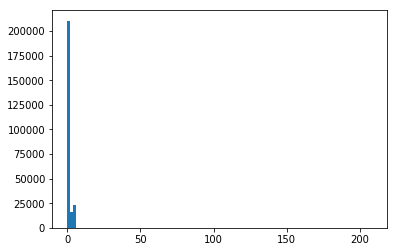

In [32]:
plt.hist(pcnt, bins = 100);

Let me zoom in to a range that makes sense in the case (vans might hold up to 15 people, then I am adding some surplus).

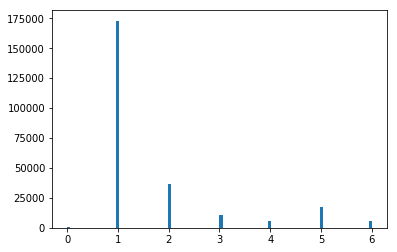

In [33]:
plt.hist(pcnt[pcnt < 20], bins = 100);

So, the maximum number of passengers below 20 is 6. I will choose that as my threshold for outliers.

In [34]:
pcnt_val = (pcnt >= 1) & (pcnt <= 6)
print(pcnt_val.value_counts(), '\n', pcnt_val.value_counts(normalize = True))

True     249138
False       862
Name: passenger_count, dtype: int64 
 True     0.996552
False    0.003448
Name: passenger_count, dtype: float64


Only one extra entry was dropped by the second condition, so 208 was the only outlier.

### Floats

#### `fare_amount`

In [35]:
fare = train['fare_amount']
fare.describe()

count    250000.000000
mean         11.328001
std           9.699137
min          -7.700000
25%           6.000000
50%           8.500000
75%          12.500000
max         400.000000
Name: fare_amount, dtype: float64

There is some weird information. 

First, the minimum value is negative, and I expect all to be positive unless an extreme altruist is riding the streets in NY. 

Then the maximum fare is $400. I suspect that is not possible within the limits of a city, unless, again, this vehicle runs on gold. 

Let me check the distribution of values graphically.

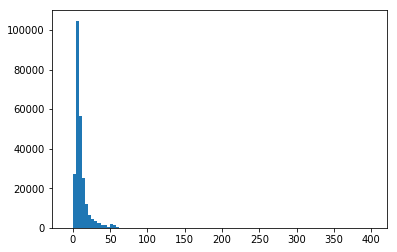

In [36]:
plt.hist(fare, bins = 100);

Most values are within \\$0 and \\$50.

I will now zoom in the lowest and largest values.

First for the values below $10.

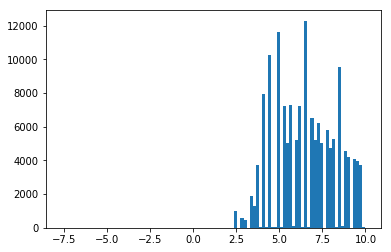

In [37]:
plt.hist(fare[fare < 10], bins = 100);

Values below ~\\$2.5 are so uncommon they don't even appear in the histogram. Besides, I believe that a fare worth less than \\$2.5 is much more probably a faulty entry in the dataset than an actual ride. For this reason, and giving it a little margin, I will choose to keep the entries were `fare > 2`.

Now for the fares above $50.

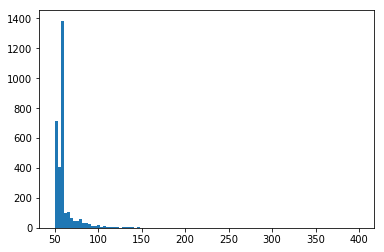

In [38]:
plt.hist(fare[fare > 50], bins = 100);

The last visible bar in the histogram is around $150. Then, I will choose to keep entries were `fare < 150`.


In [39]:
fare_val = (fare > 2) & (fare < 150)
print(fare_val.value_counts(), '\n', fare_val.value_counts(normalize = True))

True     249963
False        37
Name: fare_amount, dtype: int64 
 True     0.999852
False    0.000148
Name: fare_amount, dtype: float64


Only 37 (0.01%) were selected to be dropped.

### Tying up

Now that I decided on the decided on the cleaning protocol, let me consolidate all those conditions into a single variable.

In [40]:
val_entries = fare_val & plon_val & plat_val & dlon_val & dlat_val & pcnt_val
print(val_entries.value_counts(), '\n', val_entries.value_counts(normalize = True))

True     243718
False      6282
dtype: int64 
 True     0.974872
False    0.025128
dtype: float64


Most of the entries to be dropped had overlapping conditions, since the total amount of entries to be dropped is 6282 (2.5%). That is good, it indicates the bad data had the same origin and could be reliable discarded, and also I get to keep 97.5% of the original data.

Let me update the `train` variable to valid entries only. Since I have to choose what to drop instead of what to keep, I should drop those entries which value in `val_entries` is `False`.

In [41]:
train = train.drop(val_entries[val_entries == False].index)

## Engineering features

Now that the training set is clean, I will explore the features further.

I guess the two most important factors that affect taxi fares (and, most importantly, that can be derived from this dataset) are *duration* and *distance* of the ride.

### Duration

Unfortunately the ride duration is not given, and I cannot calculate it because the dropoff time is not given. That makes sense though, as the intention of this model is to predict fare **before** the ride.

But one thing I know to influence ride duration heavily is traffic conditions, and those can be deduced with a single time value, as - voilà! - in `pickup_datetime`.

I expect traffic to be a function of several seasonal waves. Those that I am able to extract from the data are:

* *hour of the day*: that will reflect hourly behavior; I expect, for instance, traffic to be lower at night;
* *day of the week*: that will reflect weekly behavior; I expect traffic to be lower on weekends;
* *day of the year*: that will reflect holidays and also capture seasons;
* *year*: that might have an impact on traffic due to long-term changes in traffic patterns (say, the installation of new modals of transportation).

I do not expect time lengths measured in minutes or seconds to be relevant, therefore I will keep them aside.

Besides traffic, I expect these variables to affect fare more directly. First, fares are themselves a function of demand, and it is indeed well known that fares depend on the three first attributes. Second, year is expected to capture fare changes due to wider economic traits, like inflation.

Then, let me include these features in the dataset:

In [42]:
train['hour_of_day'] = train['pickup_datetime'].map(lambda date: date.timetuple().tm_hour)
train['day_of_week'] = train['pickup_datetime'].map(lambda date: date.timetuple().tm_wday)
train['day_of_year'] = train['pickup_datetime'].map(lambda date: date.timetuple().tm_yday)
train['year'] = train['pickup_datetime'].map(lambda date: date.timetuple().tm_year)

By now I noticed something: what about leap years? Those will screw up my `day_of_year` feature, since on leap years, day 60 is March 1st instead of February 29th. Consequently, Independence Day (a holiday! demand alert!) in 2011 is usually day 185 but day 186 on leap years. Let me fix that.

The dataset concerns the period 2009-2015; only 2012 is a leap year there. First, should I drop Feb 29, 2012? How many entries are there?

In [43]:
len(train['pickup_datetime'][train['pickup_datetime'].dt.strftime('%m-%d') == '02-29'])

117

Not many. I will decide to drop them.

In [44]:
train.drop(train['pickup_datetime'][train['pickup_datetime'].dt.strftime('%m-%d') == '02-29'].index, inplace = True)

Now I must fix `day_of_year` for entries in 2012, so that March 1st will correspond to day 60 (now it is 61) and so on. In other words, if `day_of_year > 59`, then it must be updated to `day_of_year - 1`.

In [45]:
condition = (train['year'] == 2012) & (train['day_of_year'] > 59)
train['day_of_year'][condition] = train['day_of_year'] - 1

C:\Users\Denny\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Now I am curious to know if these features are indeed a proxy for traffic conditions. I do not have traffic information, but I can extrapolate them from taxi demand: more demand means more taxis riding which is closely related to more cars riding overall. I will exclude the year 2015 from this visualizations since it is incomplete (the dataset ends on mid 2015).

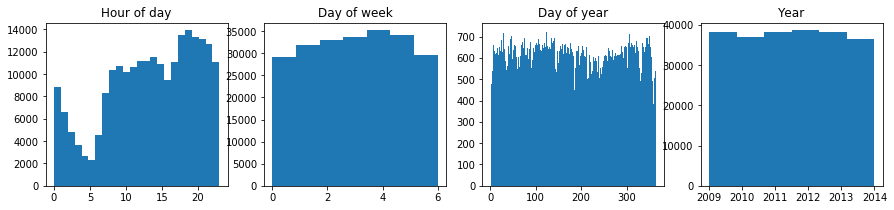

In [46]:
fig, ax = plt.subplots(1, 4, figsize = (15, 3))
train_not_2015 = train[train['year'] < 2015]
ax[0].hist(train_not_2015['hour_of_day'], bins = 24)
ax[0].set_title('Hour of day')
ax[1].hist(train_not_2015['day_of_week'], bins = 7)
ax[1].set_title('Day of week')
ax[2].hist(train_not_2015['day_of_year'], bins = 365)
ax[2].set_title('Day of year')
ax[3].hist(train_not_2015['year'], bins = 6)
ax[3].set_title('Year');

I made good guesses for feature creation.

During the day, the demand is lower around 5 am, and picks around 6 pm. <br>
During the week, it increases quite steadily from Monday to Friday, decreases a little on Satuday then drops a lot on Sunday.<br>
Throughout the year, demand starts low (New Year holidays!), then rapidly increases and stabilizes until around the day 180 (late June, Summer vacation in the US), when it drops but immediately starts increasing slowly until around Christmas, then drops to its lowest for the last days of the year.<br>
Yearly, demand was not affected. But I will keep this variable because it might have a direct impact on fare.

But now I open a long parenthesis and wonder, should I discard `pickup_datetime`? Have I extracted all valuable information from it?


#### The parenthesis!

Let me see the relationship of `pickup_datetime` to demand.

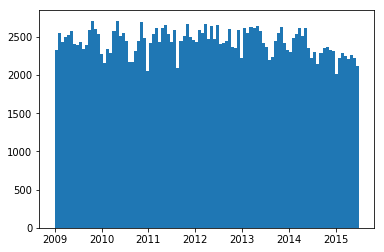

In [47]:
plt.hist(train['pickup_datetime'], bins = 100);

Nothing out of ordinary.

What else? Hmm, I will try a wild guess here. Even though `fare_amount` is influenced by the other features, I decided to check if `pickup_datetime` has some direct influence that could be highlighted from a visual inspection.

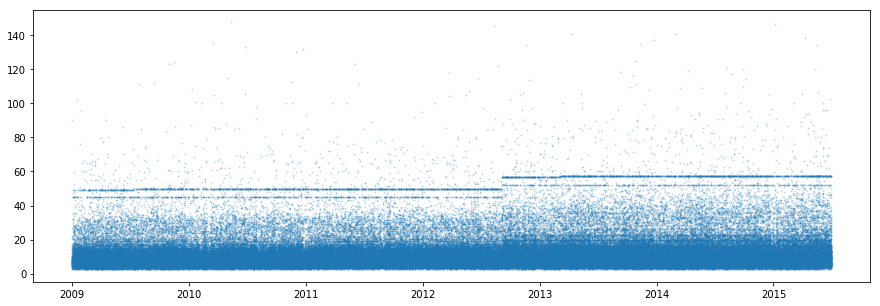

In [48]:
plt.figure(figsize = (15, 5))
plt.scatter(train['pickup_datetime'], train['fare_amount'], s = 1, alpha = 0.2)

Wow, sometimes acting nuts pays out!

In general, I do not notice anything special. But then, there are those two straight lines that appear around fares \\$45 and \\$50. Fixed fares! Quite higher than the general distribution of fares and common throughout the year, I might add. They are broken but continue, at higher fares around \\$50 and \\$60, from late 2012 on. But from these exact point in time on, all other fares increase as well. Inflation, remember?

What explains fixed fares? I have no knowledge about NYC taxi policy, but I can speculate those relate to common routes.

To investigate, I will first zoom in that fare range, and check which fares are most common.

[(57.33000183105469, 1059), (49.79999923706055, 732), (45.0, 673), (49.56999969482422, 498), (52.0, 415), (56.79999923706055, 231), (57.540000915527344, 163), (49.150001525878906, 142), (40.5, 74), (50.5, 62)]


<BarContainer object of 10 artists>

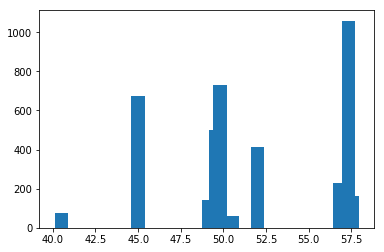

In [49]:
from collections import Counter
fare_zoom = train['fare_amount'][(train['fare_amount'] > 40) & (train['fare_amount'] < 60)]
common_fares_zoom = Counter(fare_zoom)
most_common_fares_zoom = common_fares_zoom.most_common(10)
print(most_common_fares_zoom)
plt.bar([x[0] for x in most_common_fares_zoom], [x[1] for x in most_common_fares_zoom])

I can identity that those straight lines refer to fares around \\$45 and \\$50 in the first period, then \\$52 and \\$57.5 in the second.

I will now plot the coordinates, first for all rides in the dataset, then highlighting representatives for these 'special' rides. Since I am dealing with actual coordinates, I will plot them over the map of NYC. For that, I am using the Basemap package.

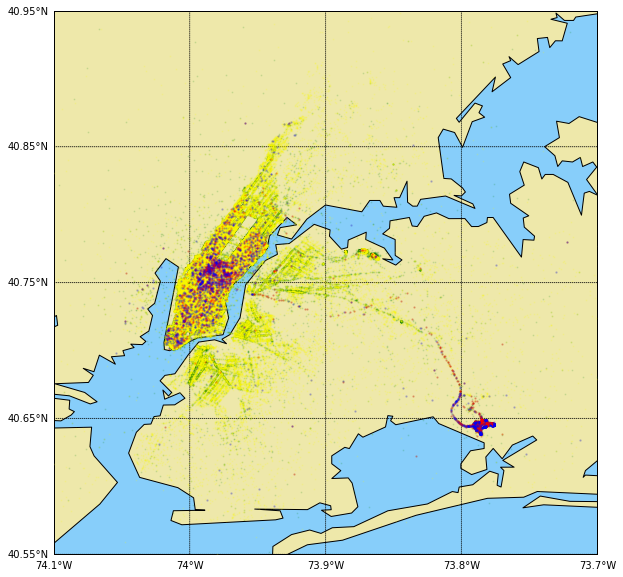

In [50]:
from mpl_toolkits.basemap import Basemap

# approximate limiting coordinates for NYC
lat1, lat2 = 40.55, 40.95 
lon1, lon2 = -74.10, -73.70

plt.figure(figsize = (10, 10))
m = Basemap(projection = 'cyl', resolution = 'h', 
            llcrnrlat = lat1, urcrnrlat = lat2,
            llcrnrlon = lon1, urcrnrlon = lon2)
m.drawcoastlines()
m.fillcontinents(color = 'palegoldenrod', lake_color = 'lightskyblue')
m.drawmapboundary(fill_color = 'lightskyblue')
m.drawparallels(np.arange(lat1, lat2 + 0.05, 0.1), labels = [1, 0, 0, 0])
m.drawmeridians(np.arange(lon1, lon2 + 0.05, 0.1), labels = [0, 0, 0, 1])
# pickup locations for all rides will be green
m.scatter(train['pickup_longitude'], train['pickup_latitude'], s = 1, c = 'green', alpha = 0.1, zorder = 5)
# dropoff locations for all rides will be yellow
m.scatter(train['dropoff_longitude'], train['dropoff_latitude'], s = 1, c = 'yellow', alpha = 0.1, zorder = 5)
for i in [0, 1, 2, 4]:
    this_fare = most_common_fares_zoom[i][0]
    this_df = train[train['fare_amount'] == this_fare]
    # 'special' pickup locations will be red
    m.scatter(this_df['pickup_longitude'], this_df['pickup_latitude'], s = 2, c = 'red', alpha = 0.2, zorder = 5)
    # 'special' dropoff locations will be blue
    m.scatter(this_df['dropoff_longitude'], this_df['dropoff_latitude'], s = 2, c = 'blue', alpha = 0.2, zorder = 5)

Nice visualization, huh? And the best part, in my opinion, is to realize that the coordinates in the training set do make sense!

From this I notice that, in general, pickups and dropoffs are spread all over the place.
But those 'special' rides are quite concentrated. First in that blob around coordinates (40.65, -73.8), second at that larger blob around coordinates (40.75, -74.0). What is special about them?

First I will extract the coordinates for the smaller blob. There are pickups as well as dropoffs in that area. Since I only need general-purpose coordinates, I will select from dropoffs only. I will also use the fare_zoom criteria to restrict the data even more to what interests me. Then I will get the median to represent that location.

In [51]:
coords = train[['dropoff_latitude', 'dropoff_longitude']][(train['fare_amount'] > 40) & 
                                                          (train['fare_amount'] < 60) &
                                                          (train['dropoff_latitude'] < 40.7) & 
                                                          (train['dropoff_latitude'] > 40.6) & 
                                                          (train['dropoff_longitude'] < -73.7) &
                                                          (train['dropoff_longitude'] > -73.9)]
print(coords['dropoff_latitude'].median(), coords['dropoff_longitude'].median())

40.645118713378906 -73.78643798828125


I entered these coordinates in Google Maps and, guess what! That is the [JFK Airport](https://goo.gl/maps/8jSzQsQKrD22)!

Now for the other blob.

In [52]:
coords = train[['dropoff_latitude', 'dropoff_longitude']][(train['fare_amount'] > 40) & 
                                                          (train['fare_amount'] < 60) &
                                                          (train['dropoff_latitude'] < 40.85) & 
                                                          (train['dropoff_latitude'] > 40.7) & 
                                                          (train['dropoff_longitude'] < -73.9) &
                                                          (train['dropoff_longitude'] > -74.1)]
print(coords['dropoff_latitude'].median(), coords['dropoff_longitude'].median())

40.755348205566406 -73.98301696777344


That is [the heart of Manhattan](https://goo.gl/maps/JF2gt6HYYj12), quite close to the Central Park (which is, by the way, those blank squares around (40.8, -74.0)!

I guess those are such common pickup/dropoff locations that NYC applies fixed fares for such rides. As for why there are two fixed fares in each period, I can only speculate. Maybe it is related to the number of passengers? Let me get `fare_amount` and `passenger_count` from the dataset, filtering for the most common fares dropping off within Manhattan.

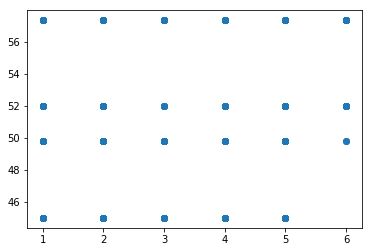

In [53]:
filtered = train[['fare_amount', 'passenger_count']][((train['fare_amount'] == most_common_fares_zoom[0][0]) |
                                                      (train['fare_amount'] == most_common_fares_zoom[1][0]) |
                                                      (train['fare_amount'] == most_common_fares_zoom[2][0]) |
                                                      (train['fare_amount'] == most_common_fares_zoom[4][0])) &
                                                     (train['fare_amount'] < 60) &
                                                     (train['dropoff_latitude'] < 40.7) & 
                                                     (train['dropoff_latitude'] > 40.6) & 
                                                     (train['dropoff_longitude'] < -73.7) &
                                                     (train['dropoff_longitude'] > -73.9)]
plt.scatter(filtered['passenger_count'], filtered['fare_amount'])

Nah, almost all fixed fares are independent of passenger count, and then, those that are not, I suspect that is only because the data is limited.

Hour of day? Day of week? Day of year?

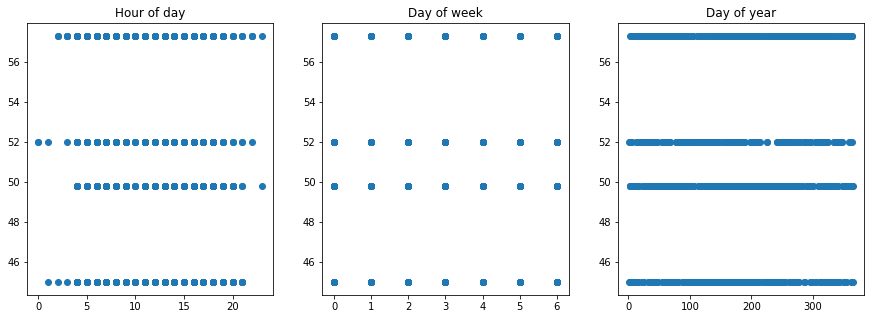

In [54]:
filtered = train[['fare_amount',
                  'hour_of_day',
                  'day_of_week',
                  'day_of_year']][((train['fare_amount'] == most_common_fares_zoom[0][0]) |
                                   (train['fare_amount'] == most_common_fares_zoom[1][0]) |
                                   (train['fare_amount'] == most_common_fares_zoom[2][0]) |
                                   (train['fare_amount'] == most_common_fares_zoom[4][0])) &
                                  (train['fare_amount'] < 60) &
                                  (train['dropoff_latitude'] < 40.7) & 
                                  (train['dropoff_latitude'] > 40.6) & 
                                  (train['dropoff_longitude'] < -73.7) &
                                  (train['dropoff_longitude'] > -73.9)]
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].scatter(filtered['hour_of_day'], filtered['fare_amount'])
ax[0].set_title('Hour of day')
ax[1].scatter(filtered['day_of_week'], filtered['fare_amount'])
ax[1].set_title('Day of week')
ax[2].scatter(filtered['day_of_year'], filtered['fare_amount'])
ax[2].set_title('Day of year');

It does not seem to be the case again. Maybe hour of day has some influence, but that is unclear at best.

That difference might be due to luggage, then. But I cannot test it. Being so, let me leave that aside.

**Conclusion of the parenthesis!**

Well, where did all this geographic digression lead me? (Remember, I started off engineering time variables.) From the feature engineering perspective, nowhere, as I am not extracting or creating any new features. But this exploration clarified me where that weird behavior of the data was coming from. Then, since now I know these fixed rates depend on pickup/dropoff coordinates, I expect a good model (especially those based on decision trees) to be able to capture these relations, without any need of further feature engineering to begin with. This exploration gave me some certainty that, for some models, this pattern in the data can be taken care of by the models themselves! That saves some valuable time.

And finally, I decided to drop `pickup_datetime` from the training set.

In [55]:
train.drop('pickup_datetime', axis = 1, inplace = True)

### Distance

At first I wondered if adding a distance metric was even necessary, as the coordinates capture the distance in a sense. But better safe than sorry!

Then... what distance measure? Euclidean is a poor proxy for taxi rides, as it stands for a straight line between the two points in space. Manhattan seems better, although NYC streets are not actually composed of a square grid. Well well, let me include both and see where that gets me.

The distance between two geographical points is not calculated on a plane, but on a spheroid object (the Earth!). Then, we need to use the haversine formula.

In [56]:
lon1, lon2 = np.radians(train['pickup_longitude']), np.radians(train['dropoff_longitude'])
lat1, lat2 = np.radians(train['pickup_latitude']), np.radians(train['dropoff_latitude'])
dlon = lon2 - lon1
dlat = lat2 - lat1

# Euclidean distance (km)
a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
train['eucl_distance'] = 6373 * c

# Manhattan distance (km)
a1 = np.sin(dlon/2)**2
c1 = 2 * np.arctan2(np.sqrt(a1), np.sqrt(1-a1))
a2 = np.sin(dlat/2)**2
c2 = 2 * np.arctan2(np.sqrt(a2), np.sqrt(1-a2))
train['manh_distance'] = 6373 * (c1+c2)

How is the distribution of the two distance measures?

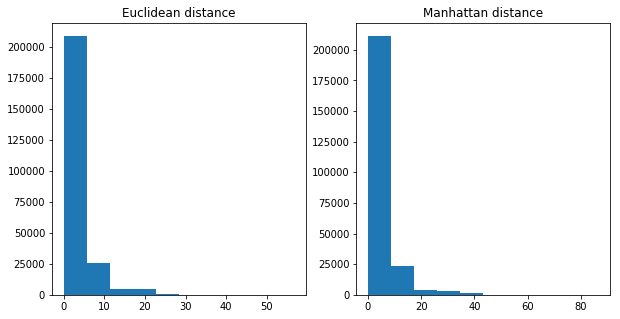

In [57]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].hist(train['eucl_distance'])
ax[0].set_title('Euclidean distance')
ax[1].hist(train['manh_distance'])
ax[1].set_title('Manhattan distance');

Most rides are quite short, and almost all are shorter than 25 km (Euclidean distance) / 45 km (Manhattan distance).

## Preprocessing

One last step before training models.

First I will separate the features from the output variable.

In [58]:
X_train = train.drop('fare_amount', axis = 1)
y_train = train['fare_amount']

Now, since I intend to test models with different requirements, I will choose to normalize all features using the MinMaxScaler.

In [59]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

C:\Users\Denny\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int32, float32, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


I am now good to go!

## Training

I will try several regression models, checking their performance by cross-validation with 3 folds, monitoring RMSE.

To speed up the process, I will also use parallel computing, setting the cross-validation function to run on all available cores minus 1.

The output of each training sell will be the RMSE of that model.

In [60]:
from sklearn.model_selection import cross_val_score
cv = 3
scoring = 'neg_mean_squared_error'

import multiprocessing
n_jobs = multiprocessing.cpu_count() - 1

### Linear Regression

In [61]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
scores = cross_val_score(model, X_train_scaled, y_train, cv = cv, scoring = scoring, n_jobs = n_jobs)
np.sqrt(-scores.mean())

4.544562517044283

### Ridge Regression

In [62]:
from sklearn.linear_model import Ridge
model = Ridge()
scores = cross_val_score(model, X_train_scaled, y_train, cv = cv, scoring = scoring, n_jobs = n_jobs)
np.sqrt(-scores.mean())

4.54490858042433

### Lasso Regression

In [63]:
from sklearn.linear_model import Lasso
model = Lasso()
scores = cross_val_score(model, X_train_scaled, y_train, cv = cv, scoring = scoring, n_jobs = n_jobs)
np.sqrt(-scores.mean())

9.497971897486826

### Nearest Neighbors

In [64]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor()
scores = cross_val_score(model, X_train_scaled, y_train, cv = cv, scoring = scoring, n_jobs = n_jobs)
np.sqrt(-scores.mean())

5.028889040907392

### Decision Tree

In [65]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
scores = cross_val_score(model, X_train_scaled, y_train, cv = cv, scoring = scoring, n_jobs = n_jobs)
np.sqrt(-scores.mean())

5.183792590110901

### Random Forest

In [66]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
scores = cross_val_score(model, X_train_scaled, y_train, cv = cv, scoring = scoring, n_jobs = n_jobs)
np.sqrt(-scores.mean())

3.8344010128194084

### Gradient Boosting

In [67]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()
scores = cross_val_score(model, X_train_scaled, y_train, cv = cv, scoring = scoring, n_jobs = n_jobs)
np.sqrt(-scores.mean())

3.8001971104727095

### Deep Learning 

In [68]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor()
scores = cross_val_score(model, X_train_scaled, y_train, cv = cv, scoring = scoring, n_jobs = n_jobs)
np.sqrt(-scores.mean())

4.211758351122579

## Inspecting the best model

The best performance was achieved by the **Gradient Boosting** method. 

After I can choose a model from the cross-validation approach, I like to train it again in a larger proportion of the dataset, then inspect the results of the training step.

To do so, first, let me split the original labeled set into a new training set consisting of 80% of the data.

### Splitting the dataset

In [69]:
from sklearn.model_selection import train_test_split

X_train1, X_test, y_train1, y_test = train_test_split(X_train_scaled, y_train, test_size = 0.20, random_state = 24)

### Training the model

In [70]:
model = GradientBoostingRegressor()
model.fit(X_train1, y_train1)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

### Inspecting the model

From tree-based models, I like to analyze two output parameters.

First, the `feature_importances_` attribute, that discriminates which features were most important to define the outcome variable.

<BarContainer object of 11 artists>

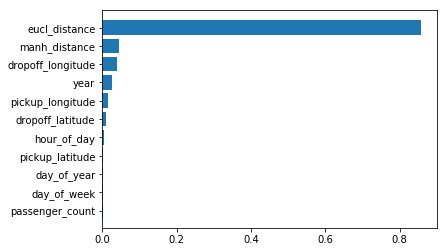

In [71]:
feature_importances = model.feature_importances_
argsort = np.argsort(feature_importances)
feature_importances_sorted = feature_importances[argsort]
feature_names = X_train.columns
features_sorted = feature_names[argsort]
plt.barh(features_sorted, feature_importances_sorted)

*Euclidean distance* was by far the most important feature impacting fare, having more than 80% of the total weight. *Manhattan distance* had a much smaller effect. The *actual coordinates* had also some minor relevance, and from the date-derived features, the most impactful were *year* and *hour of day*. The least important overall feature was *passenger count* - I would not expect that to be relevant since the same small vehicle can serve up to 3-4 passengers.

Second, let me check the RMSE score for this training session. Since the attribute `train_score_` keeps track of the scores after every round, I will retrieve only the last one.

In [72]:
mse = model.train_score_[-1]
rmse = np.sqrt(mse)
rmse

3.654316791320869

As expected (more data is always better), the error in the training set is even lower than before.

## Predicting on the test set

Now let me predict on the labeled test set I just created above (which contains 20% of the dataset).

In [73]:
y_pred = model.predict(X_test)

Then, I will check the RMSE score on this slice of data.

In [74]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

3.824264441095463

Way better than the "RMSE of \\$5 - \\$8" I was given as a baseline in the description of this callenge! 

### Comparing true and predicted outcomes

One thing I like to do around this step of the process is to compare the outcomes visually.

To do so, I will superimpose barplots comparing both outcomes. Since there are too many datapoints to include, I will opt to plot only every 0.1% of the sample size.

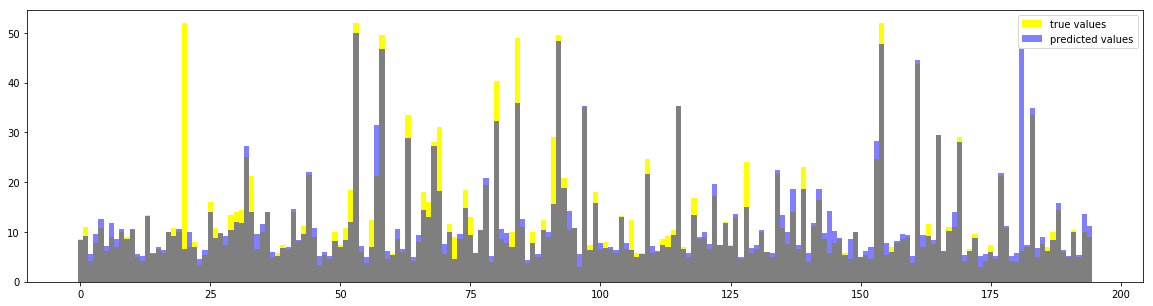

In [75]:
fig = plt.figure(figsize = (20, 5))
print_every = int(sample_size/1000)
plt.bar(list(range(len(y_test[::print_every]))), y_test.values[::print_every], alpha = 1, color = 'yellow', width = 1, label = 'true values')
plt.bar(list(range(len(y_pred[::print_every]))), y_pred[::print_every], alpha = 0.5, color = 'blue', width = 1, label = 'predicted values')
plt.legend()

I like this visual of the results because the darker area shows me where the model gets it right, while the lighter areas show me where it gets it wrong: in yellow where it underperformed, in blue where it overperformed.

Overall, given the RMSE obtained by the model, I would expect the visualization to look something like that. But I find it nice to be convinced that, even though its limitations, the model is actually working in practice!

## Answering the challenge

Finally, I will load the unlabeled `test.csv` file given in the challenge description, predict outcomes for it, and format the results as if I was going to submit my answer.

The instructions given are:

> **Submission File** <br>
> For each `key` in the test set, you must predict a value for the `fare_amount` variable. The file should contain a header and have the following format:
> 
> ```
> key,fare_amount
> 2015-01-27 13:08:24.0000002,11.00 ```

Since I need to submit the `key` as it is in the `test.csv` file, and since I am dropping it anyway before passing the data to the trained model, I will this time not parse it as a date field, load as a string instead, then save it to a variable.


In [76]:
test = pd.read_csv('test.csv', parse_dates = ['pickup_datetime'], 
                    dtype = {'key': str,
                             'pickup_latitude': np.float32, 
                             'pickup_longitude': np.float32,
                             'dropoff_latitude': np.float32,
                             'dropoff_longitude': np.float32,
                             'passenger_count': np.int32})
key = test['key']

Now I need to apply to the test set all the same transformations I did on the training set.

First, on the cleaning step:

In [77]:
pdt = test['pickup_datetime']
pdt = pdt.map(lambda date: date.tz_localize(None))
test.drop(['key'], axis = 1, inplace = True)
test['pickup_datetime'] = pdt

Second, on the feature engineering step:

In [78]:
# Duration
test['day_of_year'] = test['pickup_datetime'].map(lambda date: date.timetuple().tm_yday)
test['day_of_week'] = test['pickup_datetime'].map(lambda date: date.timetuple().tm_wday)
test['year'] = test['pickup_datetime'].map(lambda date: date.timetuple().tm_year)
test['minute_of_day'] = test['pickup_datetime'].map(lambda date: date.timetuple().tm_hour*60 + date.timetuple().tm_min)
test.drop('pickup_datetime', axis = 1, inplace = True)

# Distance
lon1, lon2 = np.radians(test['pickup_longitude']), np.radians(test['dropoff_longitude'])
lat1, lat2 = np.radians(test['pickup_latitude']), np.radians(test['dropoff_latitude'])
dlon = lon2 - lon1
dlat = lat2 - lat1

a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
test['eucl_distance'] = 6373 * c

a1 = np.sin(dlon/2)**2
c1 = 2 * np.arctan2(np.sqrt(a1), np.sqrt(1-a1))
a2 = np.sin(dlat/2)**2
c2 = 2 * np.arctan2(np.sqrt(a2), np.sqrt(1-a2))
test['manh_distance'] = 6373 * (c1+c2)

Third, on the preprocessing step:

In [79]:
X_test = test
X_test_scaled = scaler.transform(X_test)

Now I am good to predict the fares.

In [80]:
y_pred = model.predict(X_test_scaled)

I will create a dataframe with the format requested...

In [81]:
submission = pd.DataFrame({'key': key, 'fare_amount': y_pred})

... then save it to disk.

In [82]:
submission.to_csv('submission.csv', index = False)

And that is that! [Arh-wooooooooo!](https://www.urbandictionary.com/define.php?term=Howl)